In [1]:
import csv
import matplotlib.pyplot as plt 
import numpy as np
from scipy.interpolate import CubicSpline, interp1d

import h5py
import rasterio
import xarray as xr

In [2]:
import CountryData as CD

# General Imports

In [3]:
hyde = {}
FILES = ["population", "cropland", "grazing_land", "urban_population"]
for i in FILES:
    ds = xr.open_dataset('Raw_Data/HYDE34/NetCDF/'+i+'.nc', decode_times=False, chunks={})
    hyde[i] = ds[list(ds.data_vars)[0]]  

# get the years
hyde_years = (hyde["population"].time.values // 365).astype(int) + 1

In [4]:
with rasterio.open('Raw_Data/HYDE34/general/iso_cr.asc') as src:
    iso_data = src.read(1)  # Read first band

# Processing post-1600 Data

### Importing Population Data

In [5]:
# from HYDE data-set, as used in Our World in Data
Dataset = {}

with open('Raw_Data/Post1600/population.csv', 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    # Iterate over each row in the CSV file
    header = "Afghanistan"
    xs = []
    ys = []
    for row in csvreader:
        if row[0] == header: 
            xs += [int(row[2])]
            ys += [int(row[3])]
        else:
            Dataset[header] = CD.Raw_Data(header, xs, ys)
            header = row[0]
            xs = [int(row[2])]
            ys = [int(row[3])]
    
    Dataset[header] = CD.Raw_Data(header, xs, ys)

### Filtering countries

In [6]:
not_countries = [
    "Africa",
    "Asia",
    "Europe",
    "European Union (27)",
    "North America",
    "Oceania",
    "South America",
    "World"]

def is_country(name):
    if np.max(Dataset[name].xs)<2021:
        return False
    if 'UN' in name or 'income' in name:
        return False
    if name in not_countries:
        return False
    return True

Country = {}
for i in Dataset:
    if is_country(i):
        Country[i] = Dataset[i]

### Importing Birth Data

In [7]:
# from Our World in Data (I think?)

with open('Raw_Data/Post1600/births.csv', 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    # Iterate over each row in the CSV file
    header = "Afghanistan"
    xs = []
    ys = []
    for row in csvreader:
        if row[0] == header: 
            if row[3] != '':
                xs += [float(row[2])]
                ys += [float(row[3])]
        else:
            if header in Country and Country[header].xs[-1] == 2021:
                Country[header].add_births(xs, ys)
            else:
                print(header)
            header = row[0]
            if row[3] != '':
                xs = [float(row[2])]
                ys = [float(row[3])]
    if header in Dataset:
        Country[header].add_births(xs, ys)

Africa (UN)
Asia (UN)
Europe (UN)
High-income countries
Land-locked developing countries (LLDC)
Latin America and the Caribbean (UN)
Least developed countries
Less developed regions
Less developed regions, excluding China
Less developed regions, excluding least developed countries
Low-income countries
Lower-middle-income countries
More developed regions
Northern America (UN)
Oceania (UN)
Small island developing states (SIDS)
Upper-middle-income countries
Vatican
World


### Importing Life Expectancy Data

In [8]:
# from gapminder https://www.gapminder.org/data/documentation/gd004/
with open('Raw_Data/Post1600/gm-life-expectancy.csv', 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    # Iterate over each row in the CSV file
    header = "Afghanistan"
    xs = []
    ys = []
    for row in csvreader:
        if row[1] == header and float(row[2])<2025: 
            xs += [float(row[2])]
            ys += [float(row[3])]
        elif row[1]!= header:
            if header in Dataset:
                Country[header].add_LE(xs, ys)
            else:
                print(header) 
            header = row[1]
            xs = [float(row[2])]
            ys = [float(row[3])]
    Country[header].add_LE(xs, ys)

In [9]:
def proxy_LE(name,proxy):
    Country[name].add_LE(Country[proxy].LE_xs,Country[proxy].LE_ys)

LE_proxy_map = {
    "American Samoa": "Samoa",
    "Anguilla": "Saint Kitts and Nevis",
    "Aruba": "Barbados",
    "Falkland Islands": "Uruguay",
    "Faroe Islands": "Iceland",
    "French Guiana": "Suriname",
    "Greenland": "Iceland",
    "Guadeloupe": "Barbados",
    "Martinique": "Barbados",
    "Mayotte": "Comoros",
    "Montserrat": "Antigua and Barbuda",
    "New Caledonia": "Fiji",
    "Puerto Rico": "Cuba",
    "Reunion": "Mauritius",
    "Saint Pierre and Miquelon": "France",  # using France as a mainland proxy
    "Turks and Caicos Islands": "Bahamas",
    "United States Virgin Islands": "Barbados",
    "Western Sahara": "Mauritania"
}

# Apply the proxy LE data
for name, proxy in LE_proxy_map.items():
    try:
        proxy_LE(name, proxy)
    except:
        print(name, proxy)

### Importing Statista CBR Data

In [10]:
# from Statista, which in turn is fitting to 

with open('Raw_Data/Post1600/CBR.csv', 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    for row in csvreader:
        header = row[0]
        try:
            nums   = np.array([float(i) for i in row[1:]])
            Country[header].add_cbr(np.arange(1800,2016), nums)
        except: 
            if row[1]!='':
                print(header,'\t',row[1])

Channel Islands 	 35.89015
Greenland 	 34.8115
Netherlands Antilles 	 40.522
Taiwan 	 40.71235


In [11]:
def proxy_CBR(name,proxy):
    Country[name].add_cbr(Country[proxy].cbr_xs,Country[proxy].cbr_ys)

proxy_CBR('Andorra','Spain')
proxy_CBR('Dominica','Saint Vincent and the Grenadines')
proxy_CBR('Liechtenstein','Switzerland')
proxy_CBR('Saint Kitts and Nevis','Saint Vincent and the Grenadines')
proxy_CBR('South Sudan','Sudan')
proxy_CBR('Taiwan','South Korea')

for name, proxy in LE_proxy_map.items():
    if not Country[name].cbr_data:
        proxy_CBR(name, proxy)

### Importing Country Codes

In [12]:
with open('Raw_Data/HYDE34/general/country_key.csv', 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)

    for row in csvreader:
        name    = row[1].rstrip()
        hyde_id = row[0]
        try:
            Country[name].hyde_id = int(hyde_id)
        except: 
            print(name)

British Indian Ocean Territory
Christmas Isl.
Cocos (Keeling) Isl.
Heard and McDonald Isl.
Holy See
Neth.Antilles
Norfolk Island
Pitcairn
Svalbard & Jan Mayen Isl.
Serbia and Montenegro
CHE
GBR


In [13]:
# relabeling serbia and montenegro
Country['Serbia'].hyde_id = 891

In [14]:
for i in Country:
    if Country[i].hyde_id == None:
        print(i)

Bonaire Sint Eustatius and Saba
Curacao
Guernsey
Isle of Man
Jersey
Kosovo
Saint Barthelemy
Saint Martin (French part)
Sint Maarten (Dutch part)
South Sudan


### Lifetables

In [15]:
lt_regions = {
        'West': ['United States', 'Canada', 'United Kingdom', 'France', 'Germany',
            'Netherlands', 'Belgium', 'Luxembourg', 'Switzerland', 'Austria',
            'Australia', 'New Zealand', 'Ireland'],
        'North': ['Sweden', 'Norway', 'Denmark', 'Finland', 'Iceland'],
        'South': ['Spain', 'Portugal', 'Italy', 'Greece', 'Malta', 'Cyprus'],
        'East': ['Poland', 'Czechia', 'Slovakia', 'Hungary', 'Romania',
            'Bulgaria', 'Russia', 'Ukraine', 'Belarus', 'Lithuania', 
            'Latvia', 'Estonia', 'Moldova'],
        'Latin': ['Mexico', 'Brazil', 'Argentina', 'Colombia', 'Peru', 'Venezuela',
            'Chile', 'Ecuador', 'Guatemala', 'Cuba', 'Bolivia', 'Haiti',
            'Dominican Republic', 'Honduras', 'Paraguay', 'Nicaragua',
            'El Salvador', 'Costa Rica', 'Panama', 'Uruguay', 'Jamaica'],
        'Chilean': ['Chile'],
        'South_Asian': ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal',
            'Afghanistan', 'Bhutan', 'Maldives'],
        'Far_East_Asian': [
            'China', 'Japan', 'South Korea', 'North Korea', 'Taiwan',
            'Thailand', 'Vietnam', 'Philippines', 'Indonesia', 'Malaysia',
            'Singapore', 'Myanmar', 'Cambodia', 'Laos']}

In [16]:
for lt_name in lt_regions:
    for country in lt_regions[lt_name]:
        Country[country].lifetable = lt_name

## Exporting post-1600 Data

In [17]:
Final_1600_Data = {}
ID_to_country = {}
for i in Country:
    entry = Country[i]
    if entry.birth_data and entry.cbr_data and entry.LE_data:
        Final_1600_Data[i] = CD.Country_Data(entry)
        ID_to_country[Final_1600_Data[i].hyde_id] = i
    else:
        if np.sum(iso_data==entry.hyde_id)>0:
            print(i)

In [18]:
import dill
with open('Processed_Data/processed_p1600_data.pkl', 'wb') as f:
    dill.dump(Final_1600_Data, f)

# Births Map

In [19]:
from scipy.ndimage import uniform_filter

In [20]:
def hunter_gatherer_map(index):
    pop  = np.nan_to_num(hyde["population"].isel(time=index).values)
    crop    = np.nan_to_num(hyde["cropland"].isel(time=index).values)
    grazing = np.nan_to_num(hyde["grazing_land"].isel(time=index).values)
    urban   = np.nan_to_num(hyde["urban_population"].isel(time=index).values)
    
    not_hunt_gather = 1.0*((crop+grazing)>0)*(pop>0)
    not_hunt_gather = (uniform_filter(not_hunt_gather, size=15)>0.001) #blurring
        
    is_hunt_gather = 1-not_hunt_gather
    return is_hunt_gather

In [21]:
hg_array = []
for i in range(50):
    if i%10==0:
        print(i)
    hg_array += [hunter_gatherer_map(i)]

0
10
20
30
40


In [22]:
hg_array = np.array(hg_array)
with h5py.File('Processed_Data/hg_array.h5', 'w') as f:
    f.create_dataset('data', data=hg_array, compression='gzip', compression_opts=4)

In [23]:
def births_map(index):
    year = hyde_years[index]
    pop  = np.nan_to_num(hyde["population"].isel(time=index).values)
    
    if year < 1700:
        is_hunt_gather = hg_array[index]
        
        urban   = np.nan_to_num(hyde["urban_population"].isel(time=index).values)
        urban_frac = urban/(pop+1)
        
        #assign a CBR of 33 to hunter-gatherers, 45 to agriculturalists, and 35 for urban areas
        cbr_map = (1-is_hunt_gather)*(45-10*urban_frac)+is_hunt_gather*33
    else:
        cbr_map = 0.0*iso_data
        
        for i in ID_to_country:
            name = ID_to_country[i]
            cbr_map += (iso_data==i)*Final_1600_Data[name].CBR_f(year)
         
    return cbr_map*pop/1e3

In [24]:
births_array = []
for i in range(len(hyde_years)):
    if i%10==0:
        print(i)
    births_array += [births_map(i)]

0
10
20
30
40
50
60
70
80
90
100
110
120


In [25]:
births_array = np.array(births_array)
with h5py.File('Processed_Data/births_array.h5', 'w') as f:
    f.create_dataset('data', data=births_array, compression='gzip', compression_opts=4)

# Total Births

## Holocene

In [26]:
birth_vec = np.sum(births_array, axis = (1,2))

## Paleolithic

In [32]:
# Paleolithic regional population estimates (xs in kya, ys in people)
# Sources: Tallavaara et al. 2015 for Europe, archaeological/genetic evidence for others
Tallavaara_xs = np.linspace(30, 13, 18)
Tallavaara_ys = 1e3 * np.array([330, 310, 320, 250, 210, 190, 170, 140, 140, 
                                200, 190, 180, 190, 210, 260, 320, 290, 410])

HYDE_12kya = {'Africa': 228000, 'Asia': 1184000, 'Europe': 483000, 
                'North_America': 1179000, 'South_America': 1098000, 'Sahul': 260000}

#PaleoData = {
#    'Europe': {'xs': np.concatenate(([150, 50, 40], Tallavaara_xs, [12])),
#               'ys': np.concatenate(([0, 0, 300000], Tallavaara_ys, [HYDE_10000BC['Europe']]))},
#    'Sahul':  {'xs': np.array([150, 50, 40, 19, 12]), 
#               'ys': np.array([0, 0, 200000, 100000, HYDE_10000BC['Sahul']])},
#    'Asia':   {'xs': np.array([150, 70, 50, 12]), 
#               'ys': np.array([0, 0, HYDE_10000BC['Asia'], HYDE_10000BC['Asia']])},
#    'North America': {'xs': np.array([150, 30, 16, 12]), 
#                      'ys': np.array([0, 0, 100000, HYDE_10000BC['North America']])},
#    'South America': {'xs': np.array([150, 18, 12]), 
#                      'ys': np.array([0, 0, HYDE_10000BC['South America']])},
#    'Africa': {'xs': np.array([150, 70, 12]), 
#               'ys': np.array([100000, 200000, HYDE_10000BC['Africa']])},
#}

paleo_starting_date = 200 #kya
# See Claude chat
PaleoData = {
    # EUROPE
    # Before 50 kya: No H. sapiens in Europe
    # 50-45 kya: Initial colonization (Aurignacian), small populations
    # 45-30 kya: Gradual increase; Bocquet-Appel et al. suggest meta-pop ~5000 (census ~50-100k)
    # 30-13 kya: Tallavaara et al. (2015) detailed estimates
    'Europe': {
        'xs': np.concatenate(([paleo_starting_date, 50, 45, 40, 35], Tallavaara_xs, [12])),
        'ys': np.concatenate((
            [0, 0, 30_000, 80_000, 200_000],  # Early Upper Paleolithic
            Tallavaara_ys,                      # Tallavaara et al. 30-13 kya
            [HYDE_12kya['Europe']]              # HYDE anchor
        ))
    },
    
    # AFRICA
    # Primary source of H. sapiens; held majority of global population until ~50 kya
    # 150 kya: Early H. sapiens, Ne ~10-30k implies census ~100-300k (Sjödin et al. 2012)
    # 70 kya: Genetic signal of expansion (Harpending et al. 1998)
    # 50 kya: Pre-Out-of-Africa peak
    # 20 kya: LGM - some regional contraction but Africa less affected than Eurasia
    'Africa': {
        'xs': np.array([paleo_starting_date, 150, 100, 70, 50, 30, 20, 12]),
        'ys': np.array([
            100_000,    # 200 kya - ancestral population (uncertain but Ne×10)
            150_000,    # 150 kya - Sjödin et al. census range
            200_000,    # 100 kya
            350_000,    # 70 kya - expansion signal
            450_000,    # 50 kya
            400_000,    # 30 kya
            300_000,    # 20 kya - LGM
            228_000     # 12 kya - HYDE anchor
        ])
    },
    
    # ASIA (Near East, South Asia, East Asia, Southeast Asia combined)
    # Most poorly constrained region; inferred from global totals
    # 70 kya: Initial Out-of-Africa populations in Near East/South Asia
    # 50 kya: Expansion into East/Southeast Asia
    # 30 kya: Pre-LGM population
    # 20 kya: Significant LGM bottleneck, especially in northern regions
    'Asia': {
        'xs': np.array([paleo_starting_date, 70, 50, 40, 30, 20, 12]),
        'ys': np.array([
            0,           # 150 kya - no H. sapiens
            50_000,      # 70 kya - initial colonization
            300_000,     # 50 kya - expansion into E/SE Asia
            600_000,     # 40 kya - continued growth
            1_000_000,   # 30 kya - pre-LGM
            600_000,     # 20 kya - LGM bottleneck (~40% decline)
            HYDE_12kya['Asia']  # 12 kya
        ])
    },
    
    # SAHUL (Australia + New Guinea)
    # Colonization ~47 kya based on archaeology and megafauna extinction timing
    # van der Kaars et al. (2017): megafauna collapse 45-43 kya implies humans
    #   present continent-wide by ~47 kya
    # Gautney & Holliday (2015): ~47k at LGM using carnivore density method
    # Low carrying capacity: vast arid interior, only fully occupied in Holocene
    'Sahul': {
        'xs': np.array([paleo_starting_date, 50, 47, 45, 35, 25, 20, 12]),
        'ys': np.array([
            0,          # 150 kya - not colonized
            0,          # 50 kya - not yet colonized
            5_000,      # 47 kya - initial colonization
            30_000,     # 45 kya - continent-wide dispersal (megafauna extinction)
            70_000,     # 35 kya - pre-LGM growth
            50_000,     # 25 kya - early LGM contraction
            40_000,     # 20 kya - LGM minimum; interior largely abandoned
            HYDE_12kya['Sahul']  # 12 kya - recovery underway
        ])
    },
    
    # NORTH AMERICA
    # Entry ~16 kya via coastal route (possibly ice-free corridor slightly later)
    # Initial founding population small: ~1-5k effective, ~5-20k census
    # Rapid expansion: Clovis appears ~13.1 kya, continent-wide by ~12.5 kya
    # Fagundes et al. (2008), Kitchen et al. (2008)
    'North_America': {
        'xs': np.array([paleo_starting_date, 20, 16, 15, 14, 13, 12]),
        'ys': np.array([
            0,           # 150 kya - not colonized
            0,           # 20 kya - not colonized
            5_000,       # 16 kya - initial entry
            20_000,      # 15 kya - early expansion
            60_000,      # 14 kya - continued expansion
            200_000,     # 13 kya - Clovis period
            HYDE_12kya['North_America']  # 12 kya
        ])
    },
    
    # SOUTH AMERICA
    # Entry slightly after North America; Monte Verde ~14.5 kya
    # Rapid expansion down Pacific coast
    'South_America': {
        'xs': np.array([paleo_starting_date, 16, 14.5, 14, 13, 12]),
        'ys': np.array([
            0,           # 150 kya - not colonized
            0,           # 16 kya - not yet reached
            2_000,       # 14.5 kya - initial entry (Monte Verde)
            20_000,      # 14 kya - early expansion
            150_000,     # 13 kya - rapid growth
            HYDE_12kya['South_America']  # 12 kya
        ])
    },
}

# Calculate Paleolithic births per year at each time point
paleo_kya = np.linspace(paleo_starting_date, 12, 500)  # 150 kya to 12 kya
paleo_years = -1000 * paleo_kya + 2000  # convert to calendar year

paleo_world_pop = sum(np.interp(paleo_kya, PaleoData[r]['xs'][::-1], PaleoData[r]['ys'][::-1]) 
                      for r in PaleoData)
paleo_births_per_year = paleo_world_pop / 30  # ~30 year generation time

## Combined

In [33]:
# Create unified birth series (Paleolithic + Holocene)
transition_year = hyde_years[0]  # -10000

# Trim paleolithic to not overlap, combine with HYDE
paleo_mask = paleo_years < transition_year
data_years = np.concatenate([paleo_years[paleo_mask], hyde_years.astype(float)])
data_births = np.concatenate([paleo_births_per_year[paleo_mask], birth_vec])

# Interpolate birth rate at every year, then cumsum
# This assumes linear interpolation between data points (not step function)
all_years = np.arange(int(data_years[0]), int(data_years[-1]) + 1)
births_per_year = np.interp(all_years, data_years, data_births)
cumulative_births = np.cumsum(births_per_year)

print(f"Total human births: {cumulative_births[-1]/1e9:.1f} billion")
print(f"  Paleolithic: {cumulative_births[all_years < transition_year][-1]/1e9:.1f}B")
print(f"  Holocene: {(cumulative_births[-1] - cumulative_births[all_years < transition_year][-1])/1e9:.1f}B")

Total human births: 68.6 billion
  Paleolithic: 3.0B
  Holocene: 65.6B


In [34]:
# Export unified births and paleolithic regional data
with open('Processed_Data/unified_births.pkl', 'wb') as f:
    dill.dump({
        'years': all_years,
        'cumulative_births': cumulative_births,
        'total_births': cumulative_births[-1],
        'transition_year': transition_year,
    }, f)

with open('Processed_Data/paleo_regions.pkl', 'wb') as f:
    dill.dump({'regions': list(PaleoData.keys()), 'regional_data': PaleoData}, f)

print("Saved unified_births.pkl and paleo_regions.pkl")

Saved unified_births.pkl and paleo_regions.pkl


# Workspace

In [ ]:
plt.plot(all_years,cumulative_births)
plt.yscale('log')
#plt.xlim(-4e3,2e3)
plt.show()

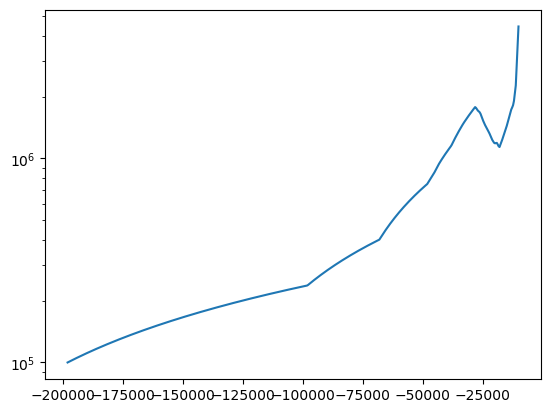

In [36]:
plt.plot(paleo_years,paleo_world_pop)
plt.yscale('log')
#plt.xlim(-4e3,2e3)
plt.show()